In [1]:
import os,sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import spsolve

sys.path.append('./src/')
import general,module,module2D
arr,pi = np.array,np.pi
absmax = lambda x: np.max(np.abs(x))

In [2]:
def CompactSchemes(Schemes,khs,nx=101,nz=101,nPML=20,sx=50.5,sz=50.5):
    for kh in khs:
        fig,ax = plt.subplots(nrows=2,ncols=len(Schemes),sharex=True,sharey=True)
        anal = module2D.Helmholtz2D(*np.meshgrid(np.arange(nx),np.arange(nz)),kh,sx,sz)
        perc = absmax(np.percentile(anal.real,[1,99]))
        fig.suptitle(r'$kh={:05.3f}\pi, 1/G={:05.3f}$'.format(kh/pi,pi/kh*2),fontsize=12)
        for i,scheme in enumerate(Schemes):
            kh = kh*np.ones((nx,nz),dtype=np.float32)
            nx,nz = kh.shape
            S = module2D.Smake(kh,nPML,scheme)
            f = module2D.getf(S,nx,nz,[sx,sz])
            wave = spsolve(S,f).reshape(nx,nz)
            diff = anal-wave
            ax[0,i].imshow(wave.real,vmin=-perc,vmax=+perc)
            ax[1,i].imshow(diff.real,vmin=-perc,vmax=+perc)
            ax[0,i].set_title(scheme.__name__)
    return fig,ax



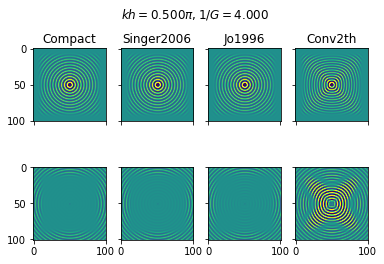

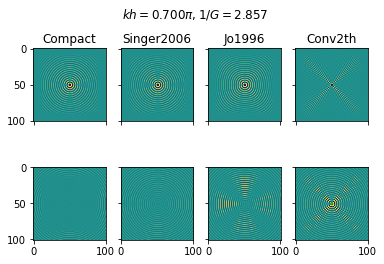

In [3]:
def Singer2006(kh):
    L,M = module.singer2006(kh,[[0,0],[0,1],[1,1]])
    return L+M 
def Conv2th(kh):
    H = arr([kh*kh-4.0,1.0,0.0])
    return H
def Jo1996(kh):
    H = module.Jo1996([[0,0],[0,1],[1,1]],kh)
    return H
#Comparison of 2d compact stencil schemes.
C9Schemes = [module.Compact,Singer2006,Jo1996,Conv2th]
fig,ax = CompactSchemes(C9Schemes, [0.5*pi,0.7*pi])
plt.show()

In [4]:
def modeling(func,stencil,kh):
    PML = makePML(kh)
    S,f = _modeling(func,stencil,PML,kh)
    wavef1D = spsolve(S,f)
    wavef2D = wavef1D.reshape((Nx,Nz))
    return wavef2D[nPML:-nPML,nPML:-nPML]

def _modeling(func,Near2D,PML,kh):
    val,row,col = [],[],[]
    PMLval,PMLrow,PMLcol = PML
    H = func(Near2D,kh)
    Near1D = Near2D.T[0]*Nz+Near2D.T[1]
    f = np.zeros(Nx*Nz,dtype=np.cfloat)
    for ix in range(nPML,Nx-nPML):
        for iz in range(nPML,Nz-nPML):
            i = ix*Nz+iz
            Near = i+Near1D
            val.extend(H)
            row.extend([i]*len(Near))
            col.extend(Near)
            if abs(sx+nPML-ix)<4.0 and abs(sz+nPML-iz)<4.0:
                f[i] = np.dot(H,module2D.Helmholtz(Near2D.T,kh,[sx+nPML-ix,sz+nPML-iz]))
    val.extend(PMLval)
    row.extend(PMLrow)
    col.extend(PMLcol)
    return csc_matrix((val,(row,col)),shape=(Nx*Nz,Nx*Nz)),f

def makePML(kh):
    PMLval,PMLrow,PMLcol = [],[],[]
    Near2D = module.Near25()
    edge = absmax(Near2D)
    Near1D = Near2D.T[0]*Nz+Near2D.T[1]
    L,M = general.HelmLM(Near2D,kh)
    for ix in range(0,Nx):
        for iz in range(0,Nz):
            i = ix*Nz+iz
            if ix<edge or iz<edge or ix>Nx-1-edge or iz>Nz-1-edge:
                PMLval.extend([1.0])
                PMLrow.extend([i])
                PMLcol.extend([i])
                continue
            if ix<nPML or iz<nPML or ix>Nx-1-nPML or iz>Nz-1-nPML:
                dx = min(0,min(ix-nPML,Nx-1-nPML-ix))/nPML
                dz = min(0,min(iz-nPML,Nz-1-nPML-iz))/nPML
                A1= 1 - 1j * dx**2 / (kh)**2.0
                A2= 1 - 1j * dz**2 / (kh)**2.0
                A12 = A1*A2
                A1221 = (A1/A2 + A2/A1 )/2.0
                PMLval.extend(A1221*L+A12*M)
                PMLrow.extend([i]*len(Near1D))
                PMLcol.extend(i+Near1D)
    return [PMLval,PMLrow,PMLcol]


In [5]:
def GeneralSchemes(Schemes,khs):
    global nx,nz,nPML,sx,sz,Nx,Nz
    nx,nz,nPML,sx,sz = 101,81,20,50.5,40.5
    Nx,Nz = nx+2*nPML,nz+2*nPML
    for kh in khs:
        X,Z = np.meshgrid(np.arange(nx),np.arange(nz))
        anal = module2D.Helmholtz2D(X.T,Z.T,kh,sx,sz)
        perc = absmax(np.percentile(anal.real,[1,99]))
        fig,ax = plt.subplots(nrows=2,ncols=len(Schemes),sharex=True,sharey=True)
        fig.set_size_inches(12,4)
        fig.suptitle(r'$kh={:05.3f}\pi, 1/G={:05.3f}$'.format(kh/pi,pi/kh*2),fontsize=12)
        for i,(scheme,stencil) in enumerate(Schemes):
            wave = modeling(scheme,stencil,kh)
            ax[0,i].imshow(wave.real,vmin=-perc,vmax=+perc)
            ax[1,i].imshow((anal-wave).real,vmin=-perc,vmax=+perc)
            ax[0,i].set_title(scheme.__name__+", p:{}".format(len(stencil)),fontdict={'fontsize':7})
    return fig,ax


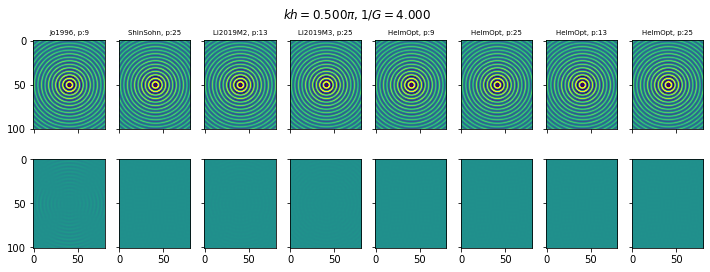

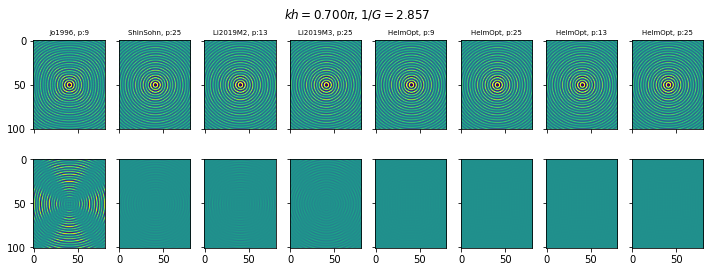

In [6]:
Methods = []
Methods.append([module.Jo1996,module.Near9()])
Methods.append([module.ShinSohn,module.Near25()])
Methods.append([module.Li2019M2,module.rhomb(2)])
Methods.append([module.Li2019M3,module.rhomb(3)])

#HelmOpt scheme gives dispersion-optimized coefficients for any grid stencil. 
#Kim et al., 2021, https://doi.org/10.1190/geo2020-0272.1
Methods.extend([[general.HelmOpt,p[1]] for p in Methods])
fig,ax = GeneralSchemes(Methods,   [0.5*pi,0.7*pi])
plt.show()